In [1]:
import numpy as np
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
from dinov2_feature_extraction import load_model, get_dense_descriptor, pca_colorize

from skimage import io



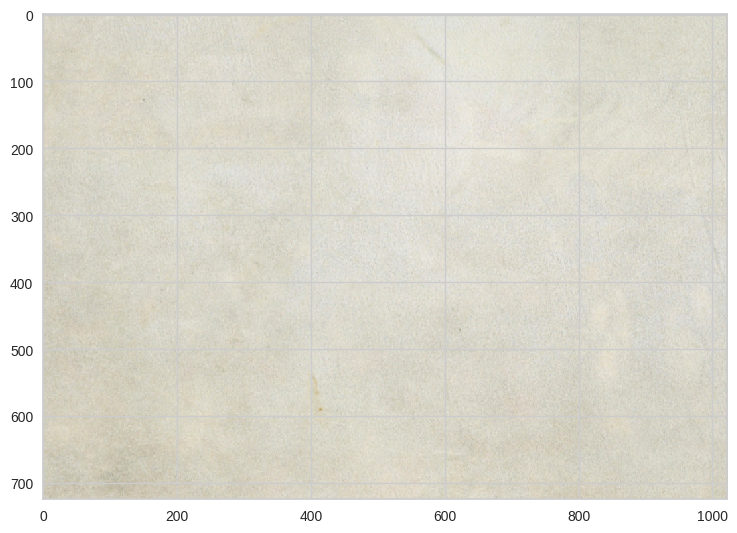

In [2]:
dataset_path_white_img_1 = r'/home/ignacio/2024-1/tesis/medieval_image_retrieval/DocExplore_images/page27.jpg'   
dataset_path_white_img_2 = r'/home/ignacio/2024-1/tesis/medieval_image_retrieval/DocExplore_images/page1328.jpg'   
img = io.imread(dataset_path_white_img_1)
io.imshow(img)
io.show()

In [3]:
dinov2_sizes = {"small": 384,
                "base": 768,
                "large": 1024,
                "giant": 1536} # tamaños del feature vector de cada version de dinov2

backbone_size = 'small'
model = load_model(backbone_size)

Using cache found in /home/ignacio/.cache/torch/hub/facebookresearch_dinov2_main
/home/ignacio/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
/home/ignacio/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
/home/ignacio/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")


In [4]:
from sklearn.decomposition import PCA

features, attention, grid_shape = get_dense_descriptor(model, img)

# Primero, aplicas PCA a tus características originales para reducir la dimensionalidad
pca = PCA(n_components=3)
pca_features = pca.fit_transform(attention)  

/home/ignacio/miniconda3/envs/medieval_ret/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/ignacio/miniconda3/envs/medieval_ret/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/ignacio/miniconda3/envs/medieval_ret/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/ignacio/miniconda3/envs/medieval_ret/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `

Optimal number of clusters: 6


/home/ignacio/miniconda3/envs/medieval_ret/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


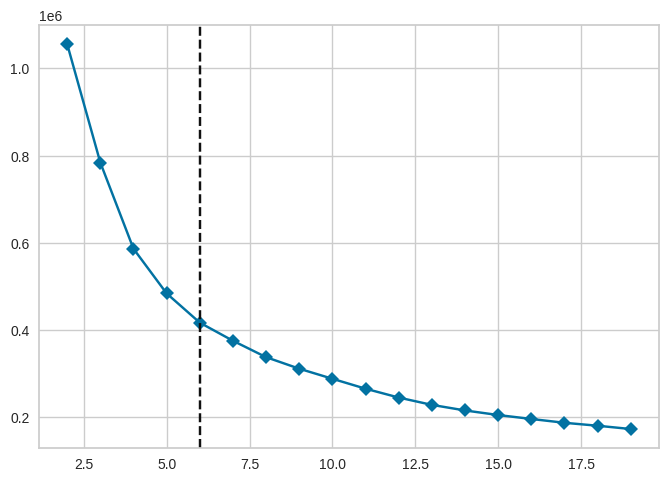

In [5]:
from sklearn.decomposition import PCA

# Initialize the KMeans model
model_kmeans = KMeans()

# Initialize the KElbowVisualizer with the number of clusters and the metric you want to use
visualizer = KElbowVisualizer(model_kmeans, k=(2,20), metric='distortion', timings=False)

# Fit the data to the visualizer
visualizer.fit(pca_features)  

# Get the optimal number of clusters
optimal_clusters = visualizer.elbow_value_

print("Optimal number of clusters:", optimal_clusters)

/home/ignacio/miniconda3/envs/medieval_ret/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


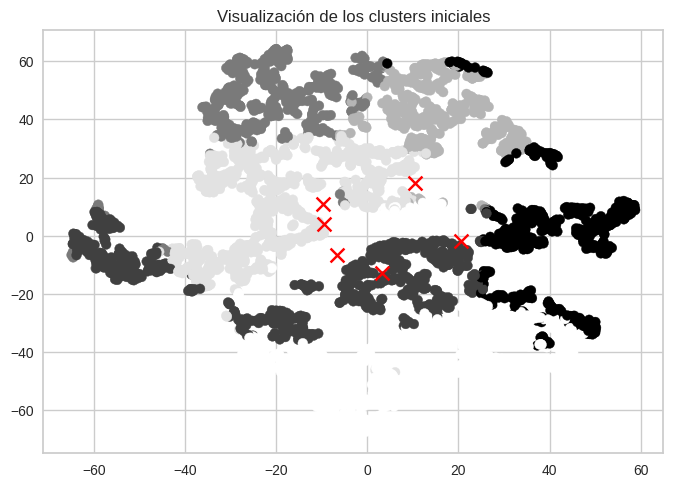

In [6]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

number_of_clusters = optimal_clusters

# Luego ajustas K-means a estas características transformadas por PCA
kmeans = KMeans(n_clusters=number_of_clusters, random_state=0)
kmeans.fit(pca_features)

# Guardas los centros de los clústeres
cluster_centers = kmeans.cluster_centers_

# Ahora para visualizar los clusters iniciales
reduced_data = TSNE(n_components=2).fit_transform(pca_features)
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=kmeans.labels_)
plt.scatter(cluster_centers[:, 0], cluster_centers[:, 1], c='red', s=100, marker='x')  # Centros de clusters
plt.title('Visualización de los clusters iniciales')
plt.show()


In [7]:
from sklearn.metrics import pairwise_distances
from skimage.filters import threshold_otsu
from sklearn.decomposition import PCA
from dinov2_feature_extraction import min_max_scale, get_dense_descriptor, foreground_mask

def pca_colorize_2_old(features, output_shape, clusters, remove_bg=False):
    pca = PCA(n_components=3)
    pca.fit(features)
    pca_features = pca.transform(features)
    pca_features = min_max_scale(pca_features)
    pca_image = pca_features.reshape(output_shape + (3,))

    if remove_bg:
        # Calcular las distancias de los canales PCA a los centroides de los clusters
        distances = pairwise_distances(pca_features.reshape(-1, 3), clusters)
        sum_of_distances = distances.sum(axis=1)
        
        # Identificar el canal con la menor suma de distancias a los centroides
        channel_distances = sum_of_distances.reshape(output_shape + (3,)).sum(axis=(0, 1))
        selected_channel = np.argmin(channel_distances)
        
        # Aplicar Otsu al canal seleccionado
        thresh = threshold_otsu(pca_image[:, :, selected_channel])
        background_mask = pca_image[:, :, selected_channel] <= thresh
        
        # Crear una máscara final y aplicarla a todos los canales
        for c in range(3):
            pca_image[background_mask, c] = 0
        
        # Reescalar los valores de la imagen resultante
        pca_image = min_max_scale(pca_image)

    return pca_image

from sklearn.metrics import pairwise_distances
from skimage.filters import threshold_otsu
from sklearn.decomposition import PCA
from dinov2_feature_extraction import min_max_scale

from sklearn.metrics import pairwise_distances


def pca_colorize_2_old_old(features, output_shape, clusters, remove_bg=False):
    # Aplica PCA para reducir la dimensionalidad a 3 componentes
    pca = PCA(n_components=3)
    pca.fit(features)
    pca_components = pca.transform(features)
    pca_components = min_max_scale(pca_components)
    pca_image = pca_components.reshape(output_shape + (3,))

    if remove_bg:
        # Calcula la distancia entre cada punto de características y los centroides de los clusters
        distances = pairwise_distances(pca_components, clusters)
        
        # Suma las distancias por componente
        summed_distances_per_component = np.sum(distances, axis=0)
        
        # Selecciona el componente con la menor suma de distancias a los centroides
        selected_component = np.argmin(summed_distances_per_component % distances.shape[0])
        
        # Aplica el umbral de Otsu al canal seleccionado
        thresh = threshold_otsu(pca_image[:, :, selected_component])
        mask = pca_image[:, :, selected_component] > thresh
        
        # Utiliza la máscara para "borrar" el fondo en todos los canales
        for i in range(3):
            pca_image[mask, i] = 0  # Coloca ceros donde la máscara es verdadera
        
        # Normaliza la imagen resultante
        pca_image = min_max_scale(pca_image)

    return pca_image

In [8]:
from sklearn.metrics import pairwise_distances


def pca_colorize_2_old_old_old(features, output_shape, clusters, remove_bg=False):
    # Aplica PCA para reducir la dimensionalidad a 3 componentes
    pca = PCA(n_components=3)
    pca.fit(features)
    pca_components = pca.transform(features)
    pca_components = min_max_scale(pca_components)
    rgb = pca_components.reshape(output_shape + (3,))

    if remove_bg:
        # Calcula la distancia entre cada punto de características y los centroides de los clusters
        distances = pairwise_distances(pca_components, clusters)
        
        # Suma las distancias para cada componente de PCA
        summed_distances = np.sum(distances, axis=1)

        # Reestructura la suma de distancias para que coincida con el formato de los componentes de PCA
        summed_distances_per_component = summed_distances.reshape(-1, 3).sum(axis=0)

        # Selecciona el componente con la menor suma de distancias a los centroides
        selected_component = np.argmin(summed_distances_per_component)

        # Determina el umbral usando el método de Otsu en el componente seleccionado
        thresh = threshold_otsu(rgb[:, :, selected_component])

        
        # Aplica la umbralización al canal seleccionado y crea una máscara
        if selected_component == 0:
            rgb_mask = (rgb[:, :, 0] > thresh) * 1
        elif selected_component == 1:
            rgb_mask = (rgb[:, :, 1] > thresh) * 1
        else: # selected_component == 2
            rgb_mask = (rgb[:, :, 2] > thresh) * 1

        
        # Aplica la máscara a todos los canales
        for c in range(3):
            rgb[:, :, c] *= rgb_mask
        
        # Reescala los valores de la imagen
        rgb = min_max_scale(rgb)

    return rgb




In [9]:
from sklearn.metrics import pairwise_distances



def pca_colorize_2_muy_old(features, output_shape, clusters, threshold, remove_bg=False):
    # Aplica PCA para reducir la dimensionalidad a 3 componentes
    pca = PCA(n_components=3)
    pca.fit(features)
    pca_components = pca.transform(features)
    pca_components = min_max_scale(pca_components)
    rgb = pca_components.reshape(output_shape + (3,))

    if remove_bg:
        # Calcula la distancia entre cada punto de características y los centroides de los clusters
        distances = pairwise_distances(pca_components, clusters)

        # Calcula la suma de las distancias a todos los centroides para cada punto
        sum_distances = np.sum(distances, axis=1)

        # Reestructura la matriz de sumas de distancias para que coincida con el formato de los componentes de PCA
        sum_distances = sum_distances.reshape(output_shape)

        # Crea una máscara basada en un umbral de distancia
        distance_mask = sum_distances < threshold

        # Aplica la máscara a todos los canales para eliminar los píxeles cercanos a los centros del cluster
        for c in range(3):
            rgb[distance_mask, c] = 0

        # Reescala los valores de la imagen
        rgb = min_max_scale(rgb)

    return rgb

In [10]:
from sklearn.metrics import pairwise_distances

def pca_colorize_2_asda(features, output_shape, centroids):
    # Realiza PCA en las características
    pca = PCA(n_components=3)
    pca.fit(features)
    rgb = pca.transform(features)
    rgb = min_max_scale(rgb)
    rgb = rgb.reshape(output_shape + (3,))
    
    # Calcula la máscara de umbral
    thresh = threshold_otsu(rgb[:, :, 0])
    mask = (rgb[:, :, 0] > thresh) * 1

    # Aplica la máscara para obtener la imagen sin fondo
    masked_rgb = rgb.copy()
    for i in range(3):  # Aplica la máscara a cada canal
        masked_rgb[:, :, i] *= mask
    
    # Calcula la distancia de la imagen sin fondo a los centroides
    dist_masked_rgb = pairwise_distances(masked_rgb.reshape(-1, 3), centroids).min(axis=1).mean()
    
    # Calcula la distancia de la máscara a los centroides
    # Esto implica que la máscara es una imagen donde solo el fondo está presente
    mask_rgb = rgb.copy()
    for i in range(3):  # Invierte la máscara para el fondo
        mask_rgb[:, :, i] *= (1 - mask)
        
    dist_mask = pairwise_distances(mask_rgb.reshape(-1, 3), centroids).min(axis=1).mean()

    print("DISNTACIA DE LA MÁSCARA: ", dist_mask)
    print("DISNTACIA DE imagen-mascara : ", dist_masked_rgb)
    # Compara las distancias y devuelve la representación que esté más cerca a los centroides
    if dist_masked_rgb <  dist_mask :
        # Devuelve la máscara si la máscara está más cerca de los centroides
        return mask
    else:
        # Devuelve la imagen sin fondo si está más cerca de los centroides
        return masked_rgb


In [11]:
def pca_colorize_2_dsad(features, output_shape):
    # Aplicar PCA como antes
    pca = PCA(n_components=3)
    pca.fit(features)
    rgb = pca.transform(features)
    rgb = min_max_scale(rgb)
    rgb = rgb.reshape(output_shape + (3,))

    # Determinar si la imagen es mayoritariamente texto o fondo
    mean_color = np.mean(rgb, axis=(0, 1))
    dominant_color = np.argmax(mean_color)

    # Aplicar umbral de Otsu al color dominante
    thresh = threshold_otsu(rgb[:, :, dominant_color])
    mask = (rgb[:, :, dominant_color] > thresh) if mean_color[dominant_color] < 0.5 else (rgb[:, :, dominant_color] < thresh)

    # Crear la máscara final
    for i in range(3):
        rgb[:, :, i] *= mask

    rgb = min_max_scale(rgb)
    return rgb

In [12]:
from decimal import Decimal, getcontext

def pca_colorize_2(features, output_shape, pca):
    # Aplicar PCA como antes
    inverted = False
    remove = True
    rgb = pca.transform(features)
    rgb = min_max_scale(rgb)
    rgb = rgb.reshape(output_shape + (3,))

    # Set the precision you need
    getcontext().prec = 10

    mean_color = np.mean(rgb, axis=(0, 1))
    print(mean_color)
    dominant_color = np.argmax(mean_color)
    print(dominant_color)
    # Convert numpy.float32 to native Python float, then to Decimal
    mean_color_0 = Decimal(float(mean_color[0]))
    mean_color_2 = Decimal(float(mean_color[2]))

    # Calculate the difference using Decimal
    diff =  mean_color_2-mean_color_0

    # Calculate the difference using Decimal
    diff_2 =  mean_color_0 - mean_color_2

    # Aplicar umbral de Otsu al color dominante
    thresh = threshold_otsu(rgb[:, :, 0])
    rgb_mask = (rgb[:, :, 0] > thresh)*1
    # Invertir la máscara si el color dominante no es el primero
    if dominant_color == 2 and diff > Decimal('1.8e-7'):
        print("invertir")
        inverted = True
        rgb_mask = 1 - rgb_mask

    elif dominant_color == 2 and diff <= Decimal('1.8e-7'):
        remove = False
    print(diff_2)
    if dominant_color == 0 and diff_2 <= Decimal('9e-8'):
        remove = False
    rgb[:, :, 0] *= rgb_mask
    rgb[:, :, 1] *= rgb_mask
    rgb[:, :, 2] *= rgb_mask
    rgb = min_max_scale(rgb)

    return rgb, inverted, remove

import os
import torch
import numpy as np
from tqdm import tqdm
from skimage import io
from skimage.transform import resize
from skimage import morphology
from skimage import measure
from skimage.filters import threshold_otsu
from sklearn.decomposition import PCA

from skimage import morphology, measure

def foreground_mask_2(attention_rgb, inverted, remove, use_bbox=True):
    # Crear la máscara básica
    attention_mask = attention_rgb.mean(axis=-1) > 0
    attention_mask = morphology.binary_dilation(attention_mask)
    if remove == False:
        print("no remove")
        # Crear una matriz de unos con las mismas dimensiones que attention_mask
        return np.ones_like(attention_mask)

    if use_bbox:
        attention_labeled = measure.label(attention_mask)
        regions = measure.regionprops(attention_labeled)
        '''
        if inverted:
            # Crear una máscara invertida donde se mantenga todo excepto las bounding boxes
            inverted_mask = np.ones_like(attention_mask, dtype=bool)
            for props in regions:
                ymin, xmin, ymax, xmax = props.bbox
                inverted_mask[ymin:ymax, xmin:xmax] = False
            return inverted_mask
        
        else:
        '''
        # Proceso normal: expandir la máscara dentro de los bounding boxes
        for props in regions:
            ymin, xmin, ymax, xmax = props.bbox
            attention_mask[ymin:ymax, xmin:xmax] = True
    
    return attention_mask

In [20]:
import numpy as np
from sklearn.decomposition import PCA
from PIL import Image

def pca_component_images(features, output_shape):
    # Aplicar PCA para obtener 3 componentes principales
    pca = PCA(n_components=3)
    pca_components = pca.fit_transform(features)

    # Función para escalar y convertir un componente en una imagen
    def component_to_image(component):
        component_scaled = (component - np.min(component)) / (np.max(component) - np.min(component))
        component_scaled = (component_scaled * 255).astype(np.uint8)
        return Image.fromarray(component_scaled.reshape(output_shape))

    # Convertir cada componente en una imagen
    image1 = component_to_image(pca_components[:, 0])
    image2 = component_to_image(pca_components[:, 1])
    image3 = component_to_image(pca_components[:, 2])

    return image1, image2, image3


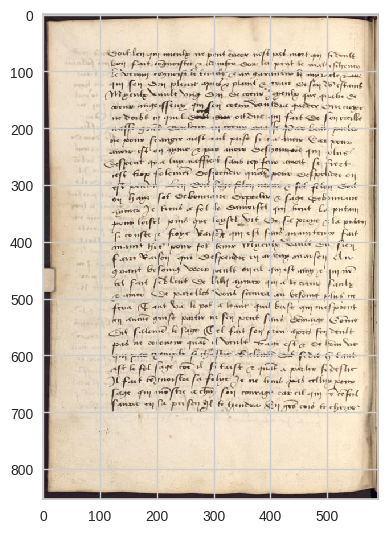

In [14]:
#dataset_path_new_img_1 = r'/home/ignacio/2024-1/tesis/medieval_image_retrieval/DocExplore_images/page1.jpg'  
#dataset_path_new_img_1 = r'/home/ignacio/2024-1/tesis/medieval_image_retrieval/DocExplore_images/page4.jpg'   
#dataset_path_new_img_1 = r'/home/ignacio/2024-1/tesis/medieval_image_retrieval/DocExplore_images/page40.jpg'   
#dataset_path_new_img_1 = r'/home/ignacio/2024-1/tesis/medieval_image_retrieval/DocExplore_images/page114.jpg'   
#dataset_path_new_img_1 = r'/home/ignacio/2024-1/tesis/medieval_image_retrieval/DocExplore_images/page104.jpg'   
dataset_path_new_img_1 = r'/home/ignacio/2024-1/tesis/medieval_image_retrieval/DocExplore_images/page32.jpg'  
new_img = io.imread(dataset_path_new_img_1)


new_image_features, new_image_attention, new_image_grid_shape = get_dense_descriptor(model, new_img)

io.imshow(new_img)
io.show()

[0.45777822 0.45777816 0.45777822]
0
0E-22


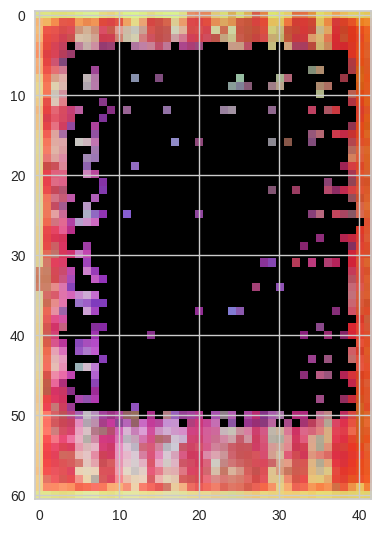

no remove


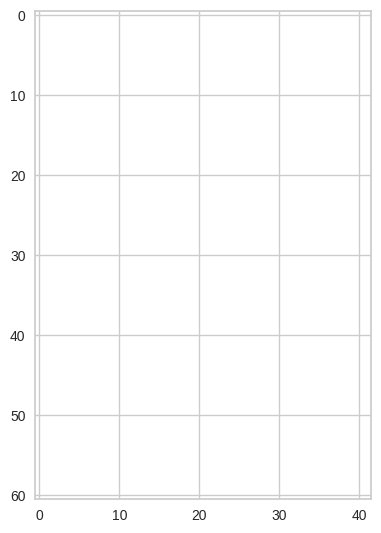

In [16]:
# Process the image and get the background component

test, inverted, remove = pca_colorize_2(new_image_attention, new_image_grid_shape)
io.imshow(test)
io.show()

'''
test_mask = foreground_mask(test, use_bbox=False)
io.imshow(test_mask)
io.show()

test_mask_box = foreground_mask(test, use_bbox=True)
io.imshow(test_mask_box)
io.show()
'''

test_mask_box_2 = foreground_mask_2(test, inverted, remove, use_bbox=True)
io.imshow(test_mask_box_2)
io.show()

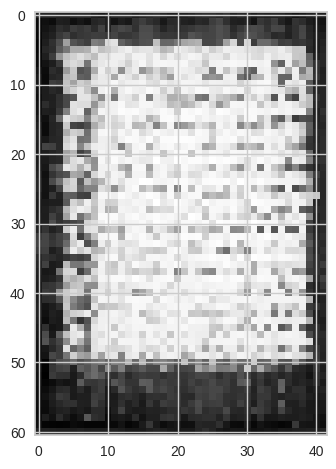

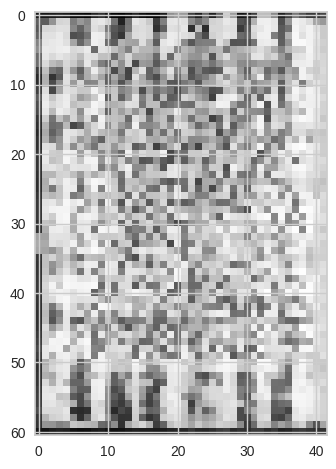

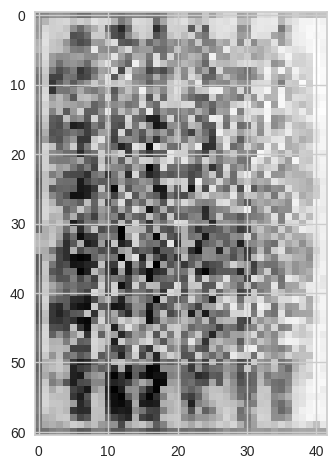

In [22]:
test1, test2, test3 = pca_component_images(new_image_attention, new_image_grid_shape)
test1_array = np.array(test1)
test2_array = np.array(test2)
test3_array = np.array(test3)

# Ahora puedes utilizar plt.imshow para mostrar las imágenes
plt.imshow(test1_array)
plt.show()
plt.imshow(test2_array)
plt.show()
plt.imshow(test3_array)
plt.show()